# **Data Import**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import scipy.stats as stats

In [8]:

data = pd.read_csv('/voc/work/marketing_data.csv')

# Data Snapshot

In [9]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,...,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,...,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,...,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,...,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,...,2,7,1,0,0,0,0,1,0,SP


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4    Income              2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

In [11]:
data.columns = data.columns.str.replace(' ', '').str.lower()

# Once data is imported, investigate variables like Dt_Customer and Income etc and check if they are imported in the right way. 

In [12]:
data.income = data.income.str.replace('[$,]', '').astype('float')

/tmp/ipykernel_126/1354050048.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data.income = data.income.str.replace('[$,]', '').astype('float')


In [13]:
data.dt_customer = pd.to_datetime(data.dt_customer)

### Income values for a few customers are missing. Perform missing value imputation. Assume that the customers with similar education and marital status make the same yearly income, on average. You may have to clean the data before performing this. For data cleaning, look into the categories of education and marital-status.



In [14]:
data.isnull().sum()

id                      0
year_birth              0
education               0
marital_status          0
income                 24
kidhome                 0
teenhome                0
dt_customer             0
recency                 0
mntwines                0
mntfruits               0
mntmeatproducts         0
mntfishproducts         0
mntsweetproducts        0
mntgoldprods            0
numdealspurchases       0
numwebpurchases         0
numcatalogpurchases     0
numstorepurchases       0
numwebvisitsmonth       0
acceptedcmp3            0
acceptedcmp4            0
acceptedcmp5            0
acceptedcmp1            0
acceptedcmp2            0
response                0
complain                0
country                 0
dtype: int64

Check categories in Marital status and education

In [15]:
data.marital_status.unique()

array(['Divorced', 'Single', 'Married', 'Together', 'Widow', 'YOLO',
       'Alone', 'Absurd'], dtype=object)

Multiple Classes in marital status might have similar interpretation such as :
- Divorced Single Widow AloneAbsurd and YOLO have same meaning as Alone
- Together and Married mean Couple 

So changing the categories accordingly 

In [16]:
def change(x):
  if x in ['Married', 'Together']:
    return 'couple'
  else :
    return 'alone'
data.marital_status = data.marital_status.apply(change) 

In [17]:
agg_data = data.groupby(['education', 'marital_status'])[['income']].mean().unstack()['income']
agg_data

marital_status,alone,couple
education,,
2n Cycle,51957.984375,45597.992647
Basic,17998.350000,21663.852941
Graduation,52615.569652,52779.380952
Master,53170.472000,52785.795833
PhD,54050.657143,57343.238562


In [18]:
for edu in data.education.unique():
  for status in data.marital_status.unique():
    val = agg_data.loc[edu, status]
    data.loc[(data.education == edu) & (data.marital_status == status) & (data.income.isnull()),'income'] = val

# Create variables to populate total number of children, age, total spend. From the number of purchases through the 3 channels, we can derive total purchases.

In [19]:
data['age'] = 2022 - data.year_birth
data['spending'] = data.loc[:,data.columns.str.startswith('mnt')].sum(axis = 1)
data['children_count'] = data.kidhome + data.teenhome
data['has_children'] = np.where((data.kidhome + data.teenhome) > 0, 1,0)
data['total_purchases'] = data.loc[:, data.columns.str.endswith('purchases')].sum(axis = 1)
data['education_years'] = data.education.replace({'Basic':5,'2n Cycle':8,'Graduation':12,'Master':18,'PhD':21})

# Create box-plots and histograms to understand the distributions and outliers. Perform outlier treatment.

In [20]:
data.columns

Index(['id', 'year_birth', 'education', 'marital_status', 'income', 'kidhome',
       'teenhome', 'dt_customer', 'recency', 'mntwines', 'mntfruits',
       'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts',
       'mntgoldprods', 'numdealspurchases', 'numwebpurchases',
       'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth',
       'acceptedcmp3', 'acceptedcmp4', 'acceptedcmp5', 'acceptedcmp1',
       'acceptedcmp2', 'response', 'complain', 'country', 'age', 'spending',
       'children_count', 'has_children', 'total_purchases', 'education_years'],
      dtype='object')

In [21]:
num_vars = ['income', 'spending', 'age', 'total_purchases']

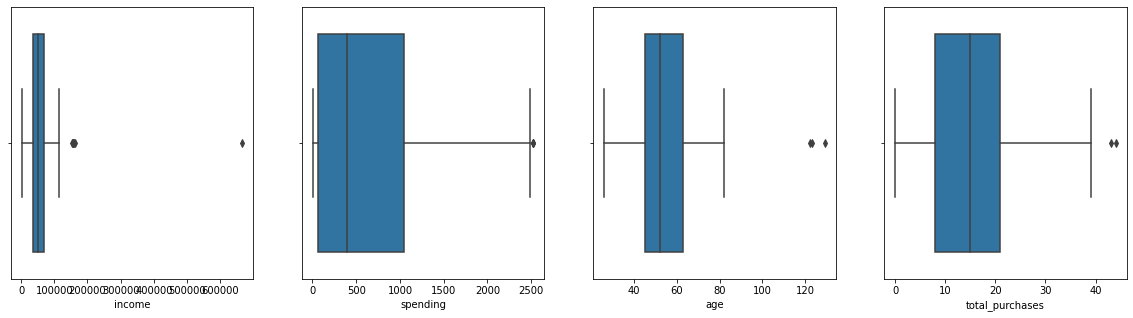

In [22]:
f,ax = plt.subplots(1, len(num_vars), figsize = (20,5))
i = 0
for v in num_vars:
  sns.boxplot(x = data[v], ax = ax[i])
  i += 1 
plt.show()

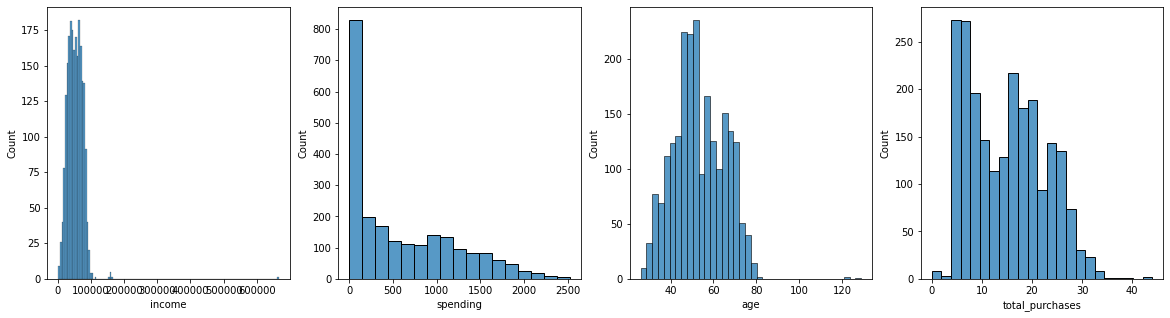

In [23]:
f,ax = plt.subplots(1, len(num_vars), figsize = (20,5))
i = 0
for v in num_vars:
  sns.histplot(x = data[v], ax = ax[i])
  i += 1 
plt.show()

- Spending is highly right skewed
- Income has extreme outliers


In [24]:
def outlier_detection(x):
  q1 = x.quantile(0.25)
  q3 = x.quantile(0.75)
  iqr = q3 - q1
  ll = q1 - (1.5 * iqr)
  ul = q3 + (1.5 * iqr)
  return ll, ul

# Cap the outliers to upper and lower limits

In [25]:
for v in num_vars:
  print("Var = ", v)
  ll,ul = outlier_detection(data[v])
  print('ll = {} ul = {}'.format(ll,ul))
  data.loc[data[v]<ll, v] = ll
  data.loc[data[v]>ul, v] = ul

Var =  income
ll = -13587.75 ul = 117416.25
Var =  spending
ll = -1396.375 ul = 2510.625
Var =  age
ll = 18.0 ul = 90.0
Var =  total_purchases
ll = -11.5 ul = 40.5


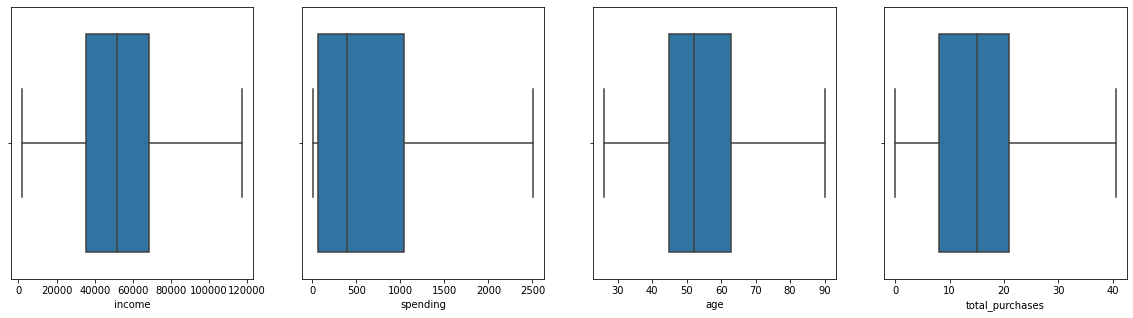

In [26]:
f,ax = plt.subplots(1, len(num_vars), figsize = (20,5))
i = 0
for v in num_vars:
  sns.boxplot(x = data[v], ax = ax[i])
  i += 1 
plt.show()

# Use ordinal encoding and one hot encoding according to different types of categorical variables.

In [27]:
data.select_dtypes('object')

,education,marital_status,country
0,Graduation,alone,SP
1,Graduation,alone,CA
2,Graduation,couple,US
3,Graduation,couple,AUS
4,Graduation,alone,SP
...,...,...,...
2235,PhD,alone,US
2236,2n Cycle,couple,SP
2237,Graduation,alone,SP
2238,Graduation,couple,IND


## For eductaion we use ordinal encoder

In [28]:
data.education.unique()

array(['Graduation', 'PhD', '2n Cycle', 'Master', 'Basic'], dtype=object)

In [29]:
ord = OrdinalEncoder(categories = [['Basic','2n Cycle','Graduation', 'Master','PhD']])
ord.fit(data[['education']])
data['education_encode'] = ord.transform(data[['education']]).flatten()

## For country and marital status use one hot encoding 

In [30]:
ohe = OneHotEncoder()

In [31]:
country_encode = pd.DataFrame(ohe.fit_transform(data[['country']]).toarray().astype(int), 
             columns = ohe.categories_[0])
country_encode

,AUS,CA,GER,IND,ME,SA,SP,US
0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
2235,0,0,0,0,0,0,0,1
2236,0,0,0,0,0,0,1,0
2237,0,0,0,0,0,0,1,0
2238,0,0,0,1,0,0,0,0


In [32]:
marital_status_encode = pd.DataFrame(ohe.fit_transform(data[['marital_status']]).toarray().astype(int), 
             columns = ohe.categories_[0])
marital_status_encode

,alone,couple
0,1,0
1,1,0
2,0,1
3,0,1
4,1,0
...,...,...
2235,1,0
2236,0,1
2237,1,0
2238,0,1


# concat these new df to old one

In [33]:
new_data = pd.concat([data, country_encode,marital_status_encode ], axis = 1)

# **OR**

In [34]:
new_data = pd.concat([data,pd.get_dummies(data[['country', 'marital_status']])], axis = 1)

In [35]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     2240 non-null   int64         
 1   year_birth             2240 non-null   int64         
 2   education              2240 non-null   object        
 3   marital_status         2240 non-null   object        
 4   income                 2240 non-null   float64       
 5   kidhome                2240 non-null   int64         
 6   teenhome               2240 non-null   int64         
 7   dt_customer            2240 non-null   datetime64[ns]
 8   recency                2240 non-null   int64         
 9   mntwines               2240 non-null   int64         
 10  mntfruits              2240 non-null   int64         
 11  mntmeatproducts        2240 non-null   int64         
 12  mntfishproducts        2240 non-null   int64         
 13  mnt

## Create a heatmap to showcase correlation between different pairs of variables.

for correlation lets consider few columns only 



In [36]:
new_data.columns

Index(['id', 'year_birth', 'education', 'marital_status', 'income', 'kidhome',
       'teenhome', 'dt_customer', 'recency', 'mntwines', 'mntfruits',
       'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts',
       'mntgoldprods', 'numdealspurchases', 'numwebpurchases',
       'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth',
       'acceptedcmp3', 'acceptedcmp4', 'acceptedcmp5', 'acceptedcmp1',
       'acceptedcmp2', 'response', 'complain', 'country', 'age', 'spending',
       'children_count', 'has_children', 'total_purchases', 'education_years',
       'education_encode', 'country_AUS', 'country_CA', 'country_GER',
       'country_IND', 'country_ME', 'country_SA', 'country_SP', 'country_US',
       'marital_status_alone', 'marital_status_couple'],
      dtype='object')

In [38]:
var_cor = ['income', 'age', 'children_count', 'recency', 'mntwines', 'mntfruits',
       'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts',
       'mntgoldprods', 'numdealspurchases', 'numwebpurchases',
       'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth','spending', 'total_purchases'
       ]

In [39]:
cor_data = new_data[var_cor].corr()

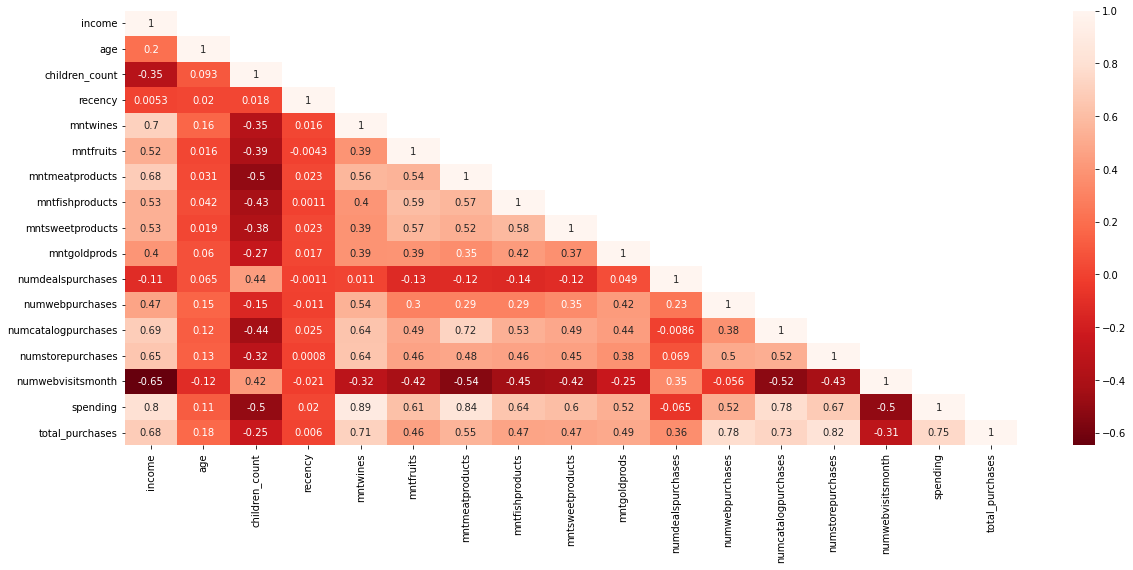

In [40]:
plt.figure(figsize = (20,8))
m = np.ones_like(cor_data)
m[np.tril_indices_from(m)]= 0
sns.heatmap(cor_data, mask = m, annot = True, cmap = 'Reds_r')
plt.show()

# **Test the following hypotheses:**

### older people are not as tech savvy and probably prefer shopping in store
#### H0 : for old customers [no. purchases store <= no. of purchases online]
#### Ha : for old customers [no. purchases store > no. of purchases online]

In [41]:
store = new_data.loc[new_data.age >= 60, 'numstorepurchases']
web = new_data.loc[new_data.age >= 60, 'numwebpurchases']
stats.ttest_ind(store,web, alternative='greater' )

Ttest_indResult(statistic=11.961244836671222, pvalue=9.218680632402673e-32)

## Since p value is much less than alpha of 5% we shall reject the null hypothesis and conclude that older customers prefer store purchases.

### customers with kids probably have less time to visit a store and would prefer to shop online
#### H0 : for customer who have children - no. purchases online <= no. of purchaes in store
#### Ha : for customer who have children - no. purchases online > no. of purchaes in store



In [42]:
online = new_data.loc[new_data.has_children == 1,'numwebpurchases']
store_p = new_data.loc[new_data.has_children == 1,'numstorepurchases']
stats.ttest_ind(online, store_p, alternative = "greater")

Ttest_indResult(statistic=-11.85534380488127, pvalue=1.0)

## Since p value = 1 and much greater than alpha of 5% we fail to reject the null hypothesis and conclude that people who have children  prefer store purchases over online purchases

### other distribution channels may cannibalize sales at the store
#### H0 : purchases other channels <= no. of store purchases
#### Ha : purchases other channels > no. of store purchases


In [43]:
other = new_data.loc[:,['numwebpurchases', 'numcatalogpurchases']].sum(axis = 1)
store = new_data.loc[:, 'numstorepurchases']
stats.ttest_ind(other, store, alternative ="greater")


Ttest_indResult(statistic=7.884334964023309, pvalue=1.971324447658957e-15)

## Since p value is much less than alpha of 5% we shall reject the null hypothesis and conclude that other distribution channels like web purchases or catalogue purchases are prefered over store purchases

### Does the US fare significantly better than the rest of the world in terms of total purchases
#### H0 : total_purchases_us <= total_purchases_row
#### Ha : total_purchases_us  > total_purchases_row

In [44]:
total_purchases_us = new_data.loc[new_data.country == "US",'total_purchases']
total_purchases_row = new_data.loc[new_data.country != "US",'total_purchases']
stats.ttest_ind(total_purchases_us ,total_purchases_row, alternative = 'greater')

Ttest_indResult(statistic=1.7339544907234352, pvalue=0.04153193317039351)

# At 5% we reject that is we can say US does better in terms of number of purchases against the rest of the world.


# Use appropriate visualization to help analyse the following:

* which products are performing the best and which are performing the least in 
terms of revenue

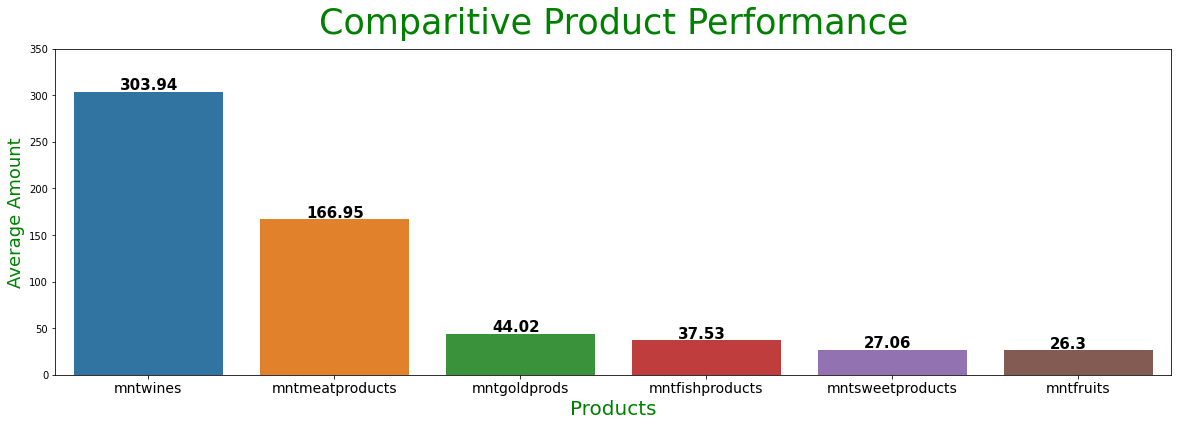

In [45]:
prod_data = new_data.loc[:,new_data.columns.str.startswith('mnt')].mean().round(2).sort_values(ascending = False)
plt.figure(figsize = (20,6))
sns.barplot(x = prod_data.index, y = prod_data.values, order=prod_data.index)
for i in range(prod_data.size):
  plt.annotate(prod_data[i], xy = (i-0.15, prod_data[i]+2), size =15 , weight = 'heavy')
plt.ylim(0, 350)
plt.xlabel( 'Products', size = 20, color = 'green')
plt.ylabel( 'Average Amount', size = 18, color = 'green')
plt.title('Comparitive Product Performance', size = 35, pad = 15, color = 'green')
plt.xticks(size = 14)
plt.show()

* Is there any pattern between the age of customers and the last campaign acceptance rate


create groups for age using histogram cut.

In [46]:
data['age_grp'] = pd.cut(data.age, bins = 5, labels = [1,2,3,4,5])

In [47]:
grpd_age = data.groupby('age_grp')['age'].agg(['min','max'])
grpd_age['group'] = grpd_age['min'].astype(str) + ' - ' +grpd_age['max'].astype(str)

Rebaming labels 

In [48]:
data.age_grp = data.age_grp.replace([1,2,3,4,5], grpd_age.group)

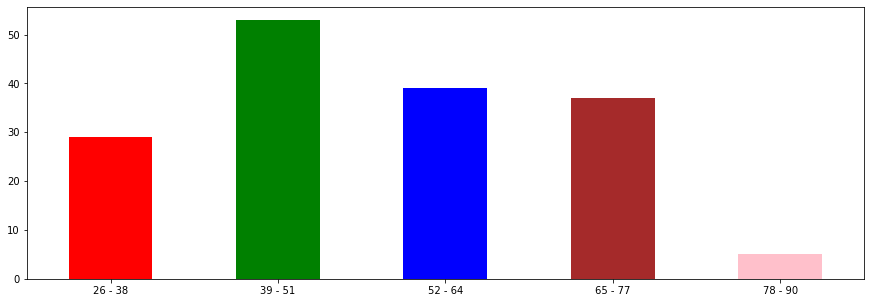

In [49]:
vc = data[data.acceptedcmp5 == 1].age_grp.value_counts().sort_index()
plt.figure(figsize = (15,5))
vc.plot.bar(color = ['red', 'green', 'blue', 'brown', 'pink'])
plt.xticks(rotation = 0)
plt.show()

age group 39 to 51 mostly accepted last campaIGN. however 78 - 90 is an agegroup which accepted the least ones


* which Country has the most number of customers who accepted the last campaign



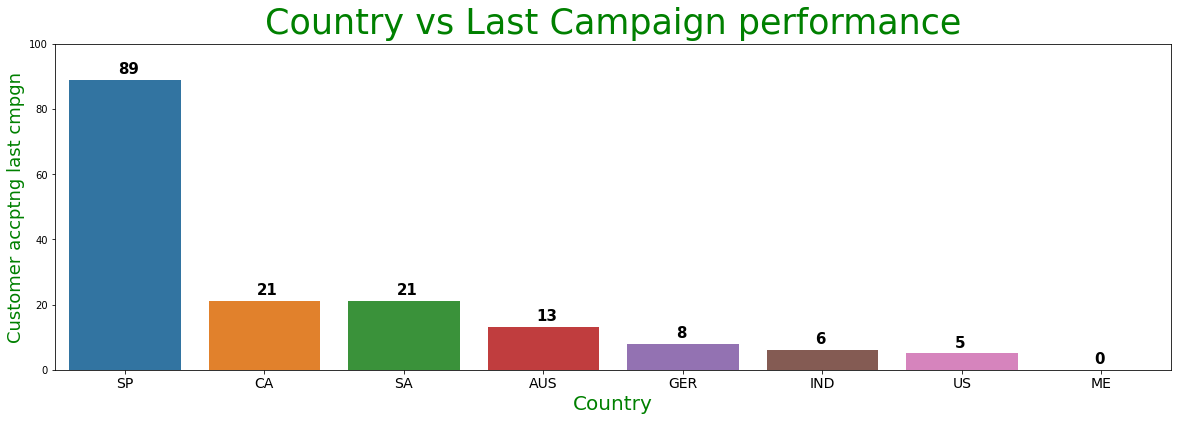

In [50]:
accptd_data = new_data.groupby('country')[['acceptedcmp5']].agg('sum').squeeze().sort_values(ascending = False)
plt.figure(figsize = (20,6))
sns.barplot(x = accptd_data.index, y = accptd_data.values, order=accptd_data.index)
for i in range(accptd_data.size):
  plt.annotate(accptd_data[i], xy = (i-0.05, accptd_data[i]+2), size =15 , weight = 'heavy')
plt.ylim(0,100)
plt.xlabel( 'Country', size = 20, color = 'green')
plt.ylabel( 'Customer accptng last cmpgn', size = 18, color = 'green')
plt.title('Country vs Last Campaign performance', size = 35, pad = 10, color = 'green')
plt.xticks(size = 14)
plt.show()

* do you see any pattern in the no of children at home and total spend


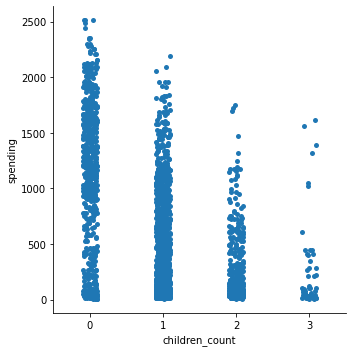

In [51]:
sns.catplot(x = 'children_count', y = 'spending',data = new_data, kind = "strip")

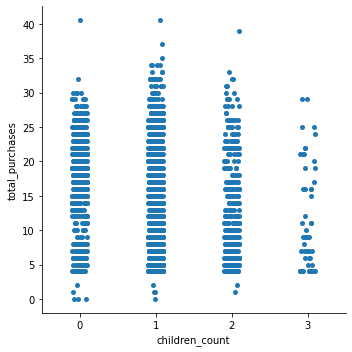

In [52]:
sns.catplot(x = 'children_count', y = 'total_purchases',data = new_data, kind = "strip")

* Education background of the customers who complained in the last 2 years

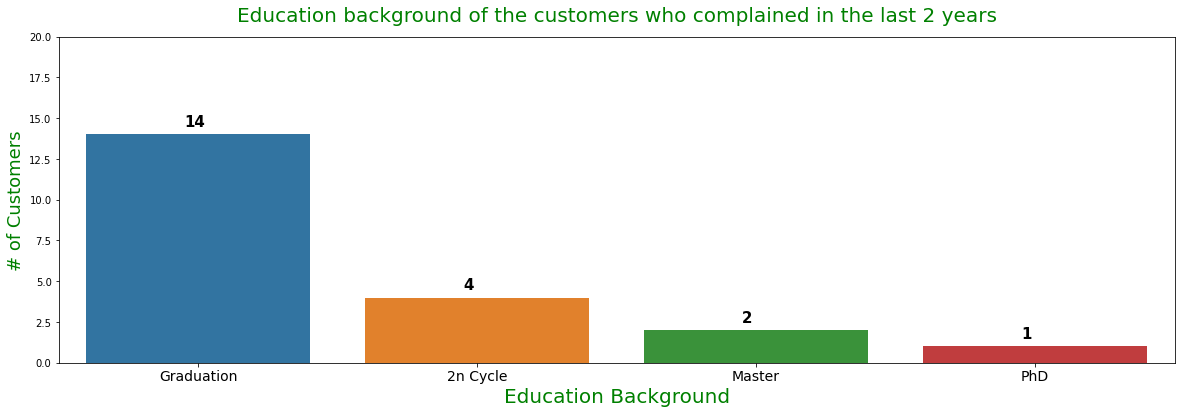

In [53]:
vc = new_data.loc[new_data.complain == 1, 'education'].value_counts()
plt.figure(figsize = (20,6))
sns.barplot(x = vc.index, y = vc.values, order=vc.index)
for i in range(vc.size):
  plt.annotate(vc[i], xy = (i-0.05, vc[i]+0.5), size =15 , weight = 'heavy')
plt.ylim(0, 20)
plt.xlabel( 'Education Background', size = 20, color = 'green')
plt.ylabel( '# of Customers', size = 18, color = 'green')
plt.title('Education background of the customers who complained in the last 2 years', size = 20, pad = 15, color = 'green')
plt.xticks(size = 14)
plt.show()

# income vs spending.

<AxesSubplot: xlabel='income', ylabel='spending'>

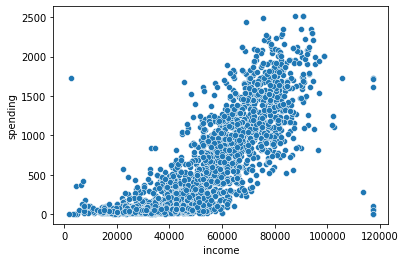

In [54]:
sns.scatterplot(x = 'income', y = 'spending', data = new_data)

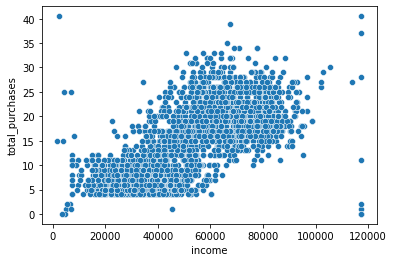

In [55]:
sns.scatterplot(x = 'income', y = 'total_purchases', data = new_data)
plt.show()

/usr/local/lib/python3.10/site-packages/seaborn/categorical.py:3025: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try stripplot
  warnings.warn(msg, UserWarning)


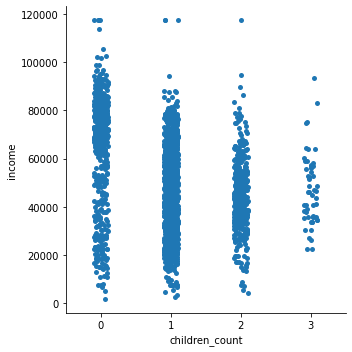

In [56]:
sns.catplot(y = 'income', x = 'children_count', data = new_data, kind = 'strip', ax = ax)
plt.show()